In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
path = os.path.join("Resources", "hawaii.sqlite")
engine = create_engine(f"sqlite:///{path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0]

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
tmin, tavg, tmax = calc_temps('2017-08-01','2017-08-07')
tmin, tavg, tmax

(72.0, 79.25, 83.0)

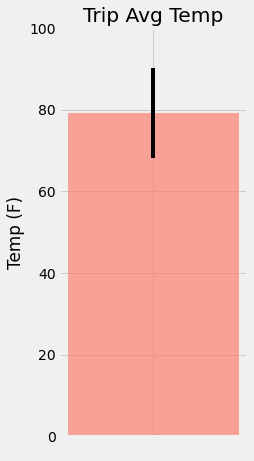

In [11]:
# Plot the results from your previous query as a bar chart.
# Use the average temperature for bar height (y value)
# Use "Trip Avg Temp" as your Title
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,7))
plt.bar(" ", tavg, color='salmon', alpha=.7)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0,100)
yerr = tmax-tmin
plt.errorbar(0, tavg, yerr=yerr, ecolor='black')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precip_query = engine.execute("\
    SELECT s.station, sum(m.prcp) as sum, s.name, s.latitude, s.longitude, s.elevation\
    FROM measurement m\
    JOIN station s\
        ON m.station = s.station\
    WHERE m.date >= '2017-08-01' AND\
        m.date <= '2017-08-07'\
    GROUP BY s.station\
    ORDER BY sum DESC")
precip_df = pd.DataFrame(precip_query, columns=["Station", "Rain", "Name", "Lat", "Lng", "Ele"])
precip_df

,Station,Rain,Name,Lat,Lng,Ele
0,USC00516128,0.36,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]

# For example
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_date = dt.date(2017,8,1)
end_date = dt.date(2017,8,7)
delta = end_date - start_date

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days=day), "%m-%d") for day in range(delta.days + 1)]
date_list

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = list(map(daily_normals, date_list))
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"], index=date_list)
normals_df

,tmin,tavg,tmax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


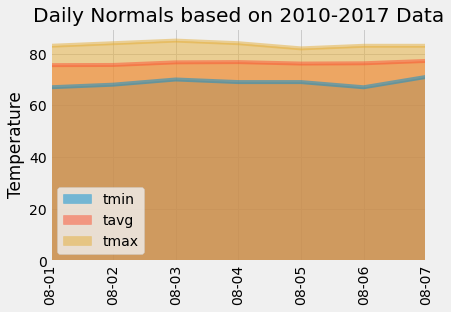

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, rot=90)
plt.title("Daily Normals based on 2010-2017 Data")
plt.xlim(0,6)
plt.ylim(0,90)
plt.ylabel("Temperature")
plt.show()

## Close Session

In [17]:
session.close()